In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Lib

In [2]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
!pip install lmfit
import lmfit
import sys
from scipy import interpolate
fill_val = 'extrapolate'
from scipy.stats import chisquare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters, report_fit,  minimize
from astropy.modeling import models, fitting
from csv import writer
from astropy.table import Table
from scipy.special import wofz
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel, PseudoVoigtModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.0 MB/s eta 0:00:00


In [3]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux, bjd

def gauss(x,a,center,sigma, gamma):
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma

def gauss_2(x,a,b, center,sigma_a, sigma_b, gamma):
  return a*np.exp(-(x-center)**2/(2*sigma_a**2))+ b*np.exp(-(x-center)**2/(2*sigma_b**2))+ gamma

### grid fitting

In [4]:
in_dir = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/*')
names = []
for i in range(0, len(in_dir)): names.append(in_dir[i].split('/')[-1])

In [ ]:
for i in range(0,len(names)):
  if names[i]=='DE_Cam': print(i)
  else: pass

87


In [ ]:
n = 87
infile = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/'+str(names[n])+'/norm/*')

In [ ]:
'''
Preprocessing for a retricted grid of sigma and amplitudes
We are limiting our fit to tyhe best SNR epoch which determines the sigma and amplitude eventually.
Also fixed the gamma to correct for normalization effect
'''

SNR = []
for infl in infile: SNR.append(fits.getheader(infl)['SNR65'])
ind = SNR.index(max(SNR))

arr = {'wave': read_HERMES(infile[ind])[0],  'flux': read_HERMES(infile[ind])[1]}
df = Table(arr).to_pandas()
linelist = [5875.62, 6678.151]

wave_data = []
flux_data = []
flux_fit = []
best_sigma = []
best_amp = []
best_gamma = []  # best normalization intercept : used for the fin al fitting procedure as a const
rvs = []  # used for defining rv grid
for line in linelist:
    data = df[(df['wave']>line-5) & (df['wave']<line+5)]
    wave_data.append(data['wave'])
    flux_data.append(data['flux'])
    model = Model(gauss)

    params = Parameters()
    params.add('a', value= 0.5)
    params.add('center', value=line)
    params.add('sigma', value= 0.5)
    params.add('gamma', value=1)
    result = model.fit(data['flux'], x=data['wave'], params=params)
    rvs.append(3*10**5*(line - result.best_values['center'])/line)
    flux_fit.append(result.best_fit)
    best_sigma.append(result.best_values['sigma'])
    best_amp.append(result.best_values['a'])
    best_gamma.append(result.best_values['gamma'])
print('RV is: ' ,rvs , 'km/s')
# rounding off amplitude and sigma values to their 4th and 3rd decimal points
amp0 = round(best_amp[0], 4)
amp1 = round(best_amp[1], 4)
sig0 = round(best_sigma[0], 3)
sig1 = round(best_sigma[1], 3)

# we need a uniform criteria to select the amplitude and sigma grid. SPacings are taken as 5% from the best fitted values
amp_0 = [amp0-0.15*amp0, amp0-0.1*amp0, amp0-0.05*amp0, amp0, amp0+0.05*amp0, amp0+0.1*amp0, amp0+0.15*amp0]
amp_1 = [amp1-0.15*amp1, amp1-0.1*amp1, amp1-0.05*amp1, amp1, amp1+0.05*amp1, amp1+0.1*amp1, amp1+0.15*amp1]
sigma_0 = [sig0-0.15*sig0, sig0-0.1*sig0, sig0-0.05*sig0, sig0, sig0+0.05*sig0, sig0+0.1*sig0, sig0+0.15*sig0]
sigma_1 = [sig1-0.15*sig1, sig1-0.1*sig1, sig1-0.05*sig1, sig1, sig1+0.05*sig1, sig1+0.1*sig1, sig1+0.15*sig1]

# finally making a list of lists that goes in the final grid
amp_list = []
sig_list = []
for i in range(0, len(amp_0)):
  for j in range(0, len(amp_1)): amp_list.append([amp_0[i], amp_1[j]])
for i in range(0, len(sigma_0)):
  for j in range(0, len(sigma_1)): sig_list.append([sigma_0[i], sigma_1[j]])


RV is:  [17.96151793579985, 14.130999904579825] km/s


In [ ]:
# restricting the rv grid significantly decrease comp time
rounded_rv = []
for rv in rvs: rounded_rv.append(round(rv, 1))
low_rv = min(rounded_rv)
max_rv = max(rounded_rv)
# rv grid
rv = np.arange(low_rv-20, max_rv+20, 2)

[1.0418718167207404, 1.0679595207540034]


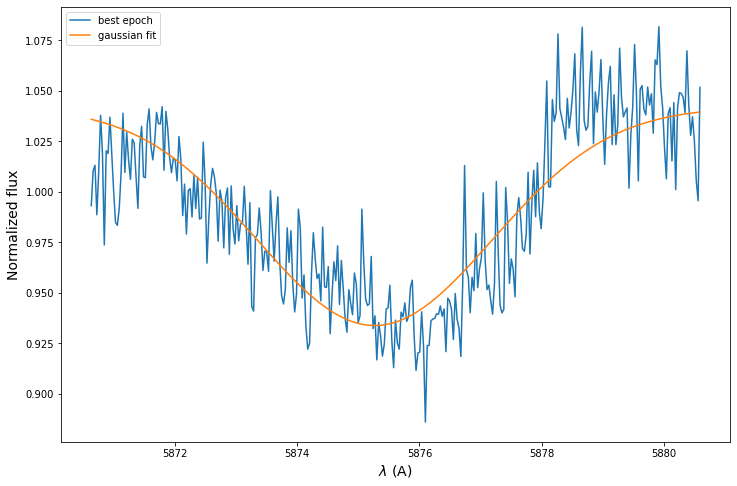

In [ ]:
'''
Checking if lmfit is stuck in a local minima. We don't want that. this will make grid unusable
'''
plt.figure(figsize = [12,8])
plt.plot(wave_data[0], flux_data[0], label = 'best epoch')
plt.plot(wave_data[0], flux_fit[0], label = 'gaussian fit')
plt.legend()
plt.xlabel('$\lambda$ (A)', size = 14)
plt.ylabel('Normalized flux', size = 14)
print(best_gamma)

In [ ]:
'''
If the fit looks okay, proceed to the next step
'''
def line(rv, line):
  return line - rv*line/(3*10**5)

epoch_chisq = []
epoch_rvels = []
chisq = []

amplitude_0 = []
amplitude_1 = []
sigmas_0 = []
sigmas_1 = []

rvels = []
epoch_chi = []
epoch_rv = []
for i in range(0, len(infile)):
  arr = {'wave': read_HERMES(infile[i])[0],  'flux': read_HERMES(infile[i])[1]}
  df = Table(arr).to_pandas()
  data1 = df[(df['wave']> 5869) & (df['wave']<5881) ]
  data2 = df[(df['wave']> 6672) & (df['wave']<6684) ]
  for a in amp_list:
    for sig in sig_list:
      for vel in rv:
          gauss_flux1 = np.array(gauss(data1['wave'], a[0], line(vel, 5875.62), sig[0], best_gamma[0]))
          chi1 = np.sum((np.array(data1['flux'] - gauss_flux1))**2)
          gauss_flux2 = np.array(gauss(data2['wave'], a[1], line(vel, 6678.15), sig[1], best_gamma[1])) #continuum at 1
          chi2 = np.sum((np.array(data2['flux'] - gauss_flux2))**2)
          chisq.append(chi1+chi2)
          amplitude_0.append(a[0])
          sigmas_0.append(sig[0])
          amplitude_1.append(a[1])
          sigmas_1.append(sig[1])
          rvels.append(vel)
          epoch_chi.append(chi1+chi2)
          epoch_rv.append(vel)
  epoch_chisq.append(epoch_chi)
  epoch_rvels.append(epoch_rv)

In [ ]:
from scipy.stats import chi2

dof = len(data1['wave']) + len(data2['wave']) - len(rvs) - 4
epoch_red_chisq = []
sigma_rv = []
for i in range(0, len(epoch_chisq)):
  alpha = dof/min(epoch_chisq[i])
  sigma = chi2.isf(0.32, dof)
  reduced_chi = np.array(epoch_chisq[i])*alpha
  sigma_rv.append(sigma)
  epoch_red_chisq.append(reduced_chi)

plt.figure(figsize= [12,8])
plt.scatter(epoch_rvels[2], epoch_red_chisq[2], marker = '.', color = 'b')
plt.axhline(sigma, color = 'r')
plt.ylim(700, 900)

In [ ]:
k = 0
arr = {'chi': epoch_red_chisq[k], 'vels': epoch_rvels[k]}
df = Table(arr).to_pandas()
data = df[df['chi']< sigma_rv[k]]
ind = epoch_chisq[k].index(min(epoch_chisq[k]))
epoch_rvels[k][ind]

print('best velocity : ', epoch_rvels[k][ind])
print('min velocity : ', min(data['vels']))
print('max velocity : ', max(data['vels']))

### lmfit

In [5]:
def bestline(rv, line):
  return line - rv*line/(3*10**5)

def gauss(x,a,rv,sigma, gamma, line):
  return a*np.exp(-(x-bestline(rv, line))**2/(2*sigma**2)) + gamma

In [6]:
in_dir = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/*')
names = []
for i in range(0, len(in_dir)): names.append(in_dir[i].split('/')[-1])

In [ ]:
names

Input takes n as the index number of the star. Rest is automatic

HD_195407


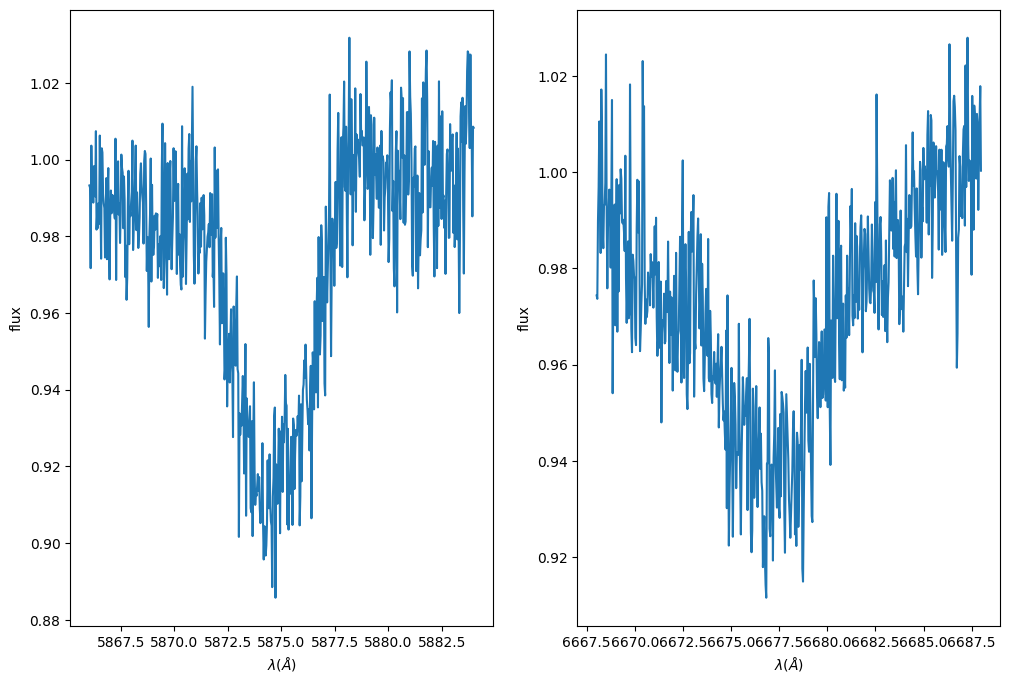

In [8]:
n = 45

infile = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/'+str(names[n])+'/norm/*')
arr = {'wave': read_HERMES(infile[0])[0],  'flux': read_HERMES(infile[0])[1]}
df = Table(arr).to_pandas()
data1 = df[(df['wave']> 5866) & (df['wave']<5884)]
data2 = df[(df['wave']> 6668) & (df['wave']<6688)]

fig, ax = plt.subplots(1,2, figsize = [12,8])
ax[0].plot(data1['wave'], data1['flux'])
ax[1].plot(data2['wave'], data2['flux'])
ax[0].set_xlabel('$\lambda (\AA)$')
ax[0].set_ylabel('flux')
ax[1].set_xlabel('$\lambda (\AA)$')
ax[1].set_ylabel('flux')
print(names[n])

In [ ]:
import csv
data = ['epoch', 'rv', 'rv_err', 'amp_58', 'sig_58', 'gamma_58', 'amp_68', 'sig_68', 'gamma_66']
with open('/content/drive/MyDrive/thesis_final_results/multi_wave/rvs/'+str(names[n])+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(data)
    f.close()


In [ ]:
infile = glob.glob('/content/drive/MyDrive/hermes_RVs/normalized_spectra/'+str(names[n])+'/norm/*')

params = Parameters()
for i in range(0, len(infile)):
  params.add('rv'+str(i), value = 10)
  params.add('gamma_58_'+str(i), value = 1)
  params.add('gamma_66_'+str(i), value = 1)

params.add('a1', value =-0.07)
params.add('sigma1', value = 2.5)
params.add('a2', value =-0.07)
params.add('sigma2', value = 2.5)

def objective(params, infile):
    a1 = params['a1']
    sigma1 = params['sigma1']
    a2 = params['a2']
    sigma2 = params['sigma2']

    data_1, data_2, m_1, m_2 = [], [], [], []
    for k in range(0, len(infile)):
      arr = {'wave': read_HERMES(infile[k])[0],  'flux': read_HERMES(infile[k])[1]}
      df = Table(arr).to_pandas()
      data1 = df[(df['wave']> 5866) & (df['wave']<5884)]
      data2 = df[(df['wave']> 6668) & (df['wave']<6688)]
      m_1.append(gauss(data1['wave'], a1, params['rv'+str(k)], sigma1, params['gamma_58_'+str(k)], 5875.62))
      m_2.append(gauss(data2['wave'], a2, params['rv'+str(k)], sigma2, params['gamma_66_'+str(k)], 6678.15))
      data_1.append(data1['flux'])
      data_2.append(data2['flux'])

    list_1 = []
    list_2 = []
    for i in range(0, len(infile)):
      list_1.append(np.array(data_1[i])-np.array(m_1[i]))
      list_2.append(np.array(data_2[i])-np.array(m_2[i]))
    list_0 = list_1 + list_2
    array  = np.concatenate(list_0)

    return array

result = minimize(objective, params=params, args =[infile])
result

In [ ]:
for i in range(0, len(infile)):
  dt = [i, result.params['rv'+str(i)].value, result.params['rv'+str(i)].stderr, result.params['a1'].value, result.params['sigma1'].value, result.params['gamma_58_'+str(i)].value, result.params['a2'].value, result.params['sigma2'].value, result.params['gamma_66_'+str(i)].value]
  from csv import writer
  with open('/content/drive/MyDrive/thesis_final_results/multi_wave/rvs/'+str(names[n])+'.csv', 'a') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(dt)
    f_object.close()

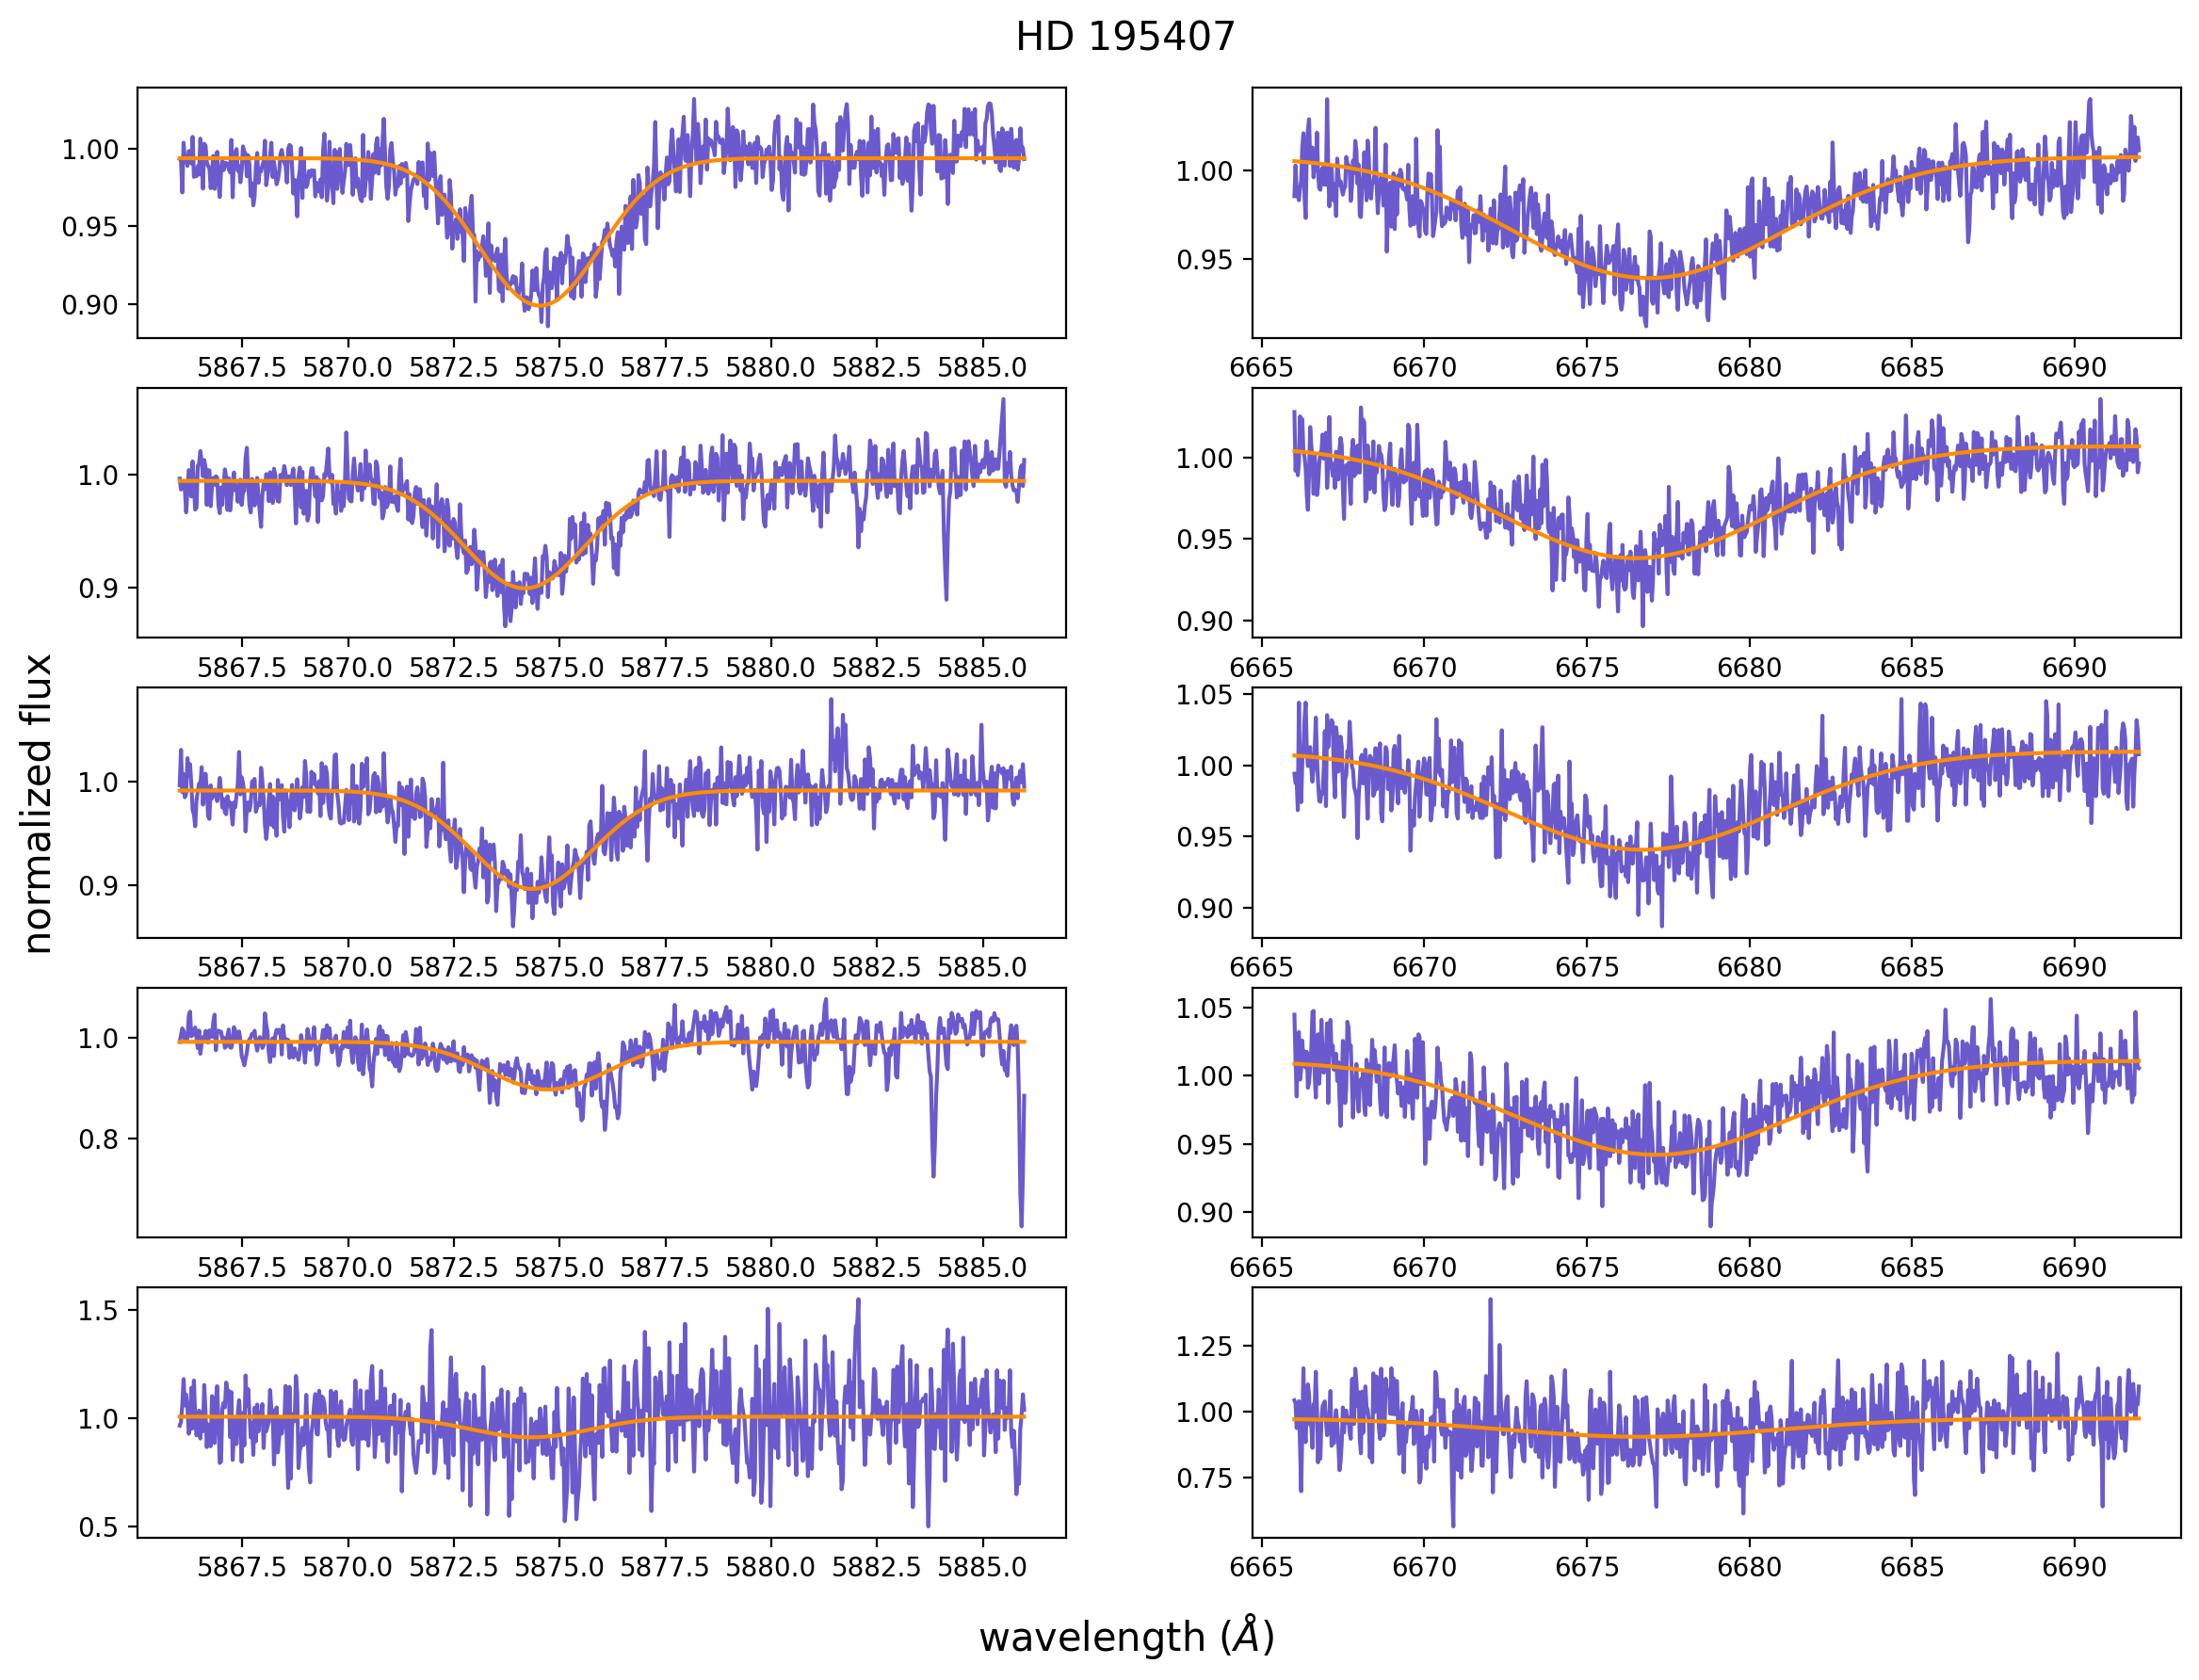

In [30]:
if len(infile) == 1:
  fig, ax = plt.subplots(nrows=len(infile), ncols=2, figsize=(14, 5), sharex=True, sharey=True)
  #fig.suptitle(str(names[n]), size = 15)
  fig.text(0.5, 0.04, 'normalized flux', ha='center')
  fig.text(0.04, 0.5, 'wavelength ($\AA$)', va='center', rotation='vertical')

  arr = {'wave': read_HERMES(infile[0])[0],  'flux': read_HERMES(infile[0])[1]}
  df = Table(arr).to_pandas()
  data1 = df[(df['wave']> 5864) & (df['wave']<5886)]
  data2 = df[(df['wave']> 6668) & (df['wave']<6688)]
  fit1 = gauss(data1['wave'], result.params['a1'].value, result.params['rv0'].value, result.params['sigma1'].value, result.params['gamma_58_0'].value, 5875.62)
  fit2 = gauss(data2['wave'], result.params['a2'].value, result.params['rv0'].value, result.params['sigma2'].value, result.params['gamma_66_0'].value, 6678.15)
  ax[0].plot(data1['wave'], data1['flux'], color = 'b')
  ax[0].plot(data1['wave'], fit1, color = 'r')
  ax[1].plot(data2['wave'], data2['flux'], color = 'b')
  ax[1].plot(data2['wave'], fit2, color = 'r')

else:
  fig, ax = plt.subplots(nrows=len(infile), ncols=2, figsize=(14, 10), dpi = 200)
  #fig.suptitle(str(names[n]), size = 15)
  fig.text(0.5, 0.9, 'HD 195407', ha='center', size = 15)

  fig.text(0.5, 0.05, 'wavelength ($\AA$)', ha='center', size = 15)
  fig.text(0.08, 0.5, 'normalized flux', va='center', rotation='vertical', size = 15)

  for i in range(0, len(infile)):
    arr = {'wave': read_HERMES(infile[i])[0],  'flux': read_HERMES(infile[i])[1]}
    df = Table(arr).to_pandas()
    data1 = df[(df['wave']> 5866) & (df['wave']<5886)]
    data2 = df[(df['wave']> 6666) & (df['wave']<6692)]
    fit1 = gauss(data1['wave'], result.params['a1'].value, result.params['rv'+str(i)].value, result.params['sigma1'].value, result.params['gamma_58_'+str(i)].value, 5875.62)
    fit2 = gauss(data2['wave'], result.params['a2'].value, result.params['rv'+str(i)].value, result.params['sigma2'].value, result.params['gamma_66_'+str(i)].value, 6678.15)

    ax[i,0].plot(data1['wave'], data1['flux'], color = 'slateblue')
    ax[i,0].plot(data1['wave'], fit1, color = 'darkorange')
    ax[i,1].plot(data2['wave'], data2['flux'], color = 'slateblue')
    ax[i,1].plot(data2['wave'], fit2, color = 'darkorange')
#plt.savefig('/content/drive/MyDrive/thesis_final_results/multi_wave/fits/'+str(names[n])+'.png')
plt.savefig('multigrid.png', transparent=True)